In [1]:
%matplotlib inline

import covid19_WebScrapes # contains functions to scrape various sources
import algosdk
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Read in Patient Test Data

In [3]:
testing_scrape = covid19_WebScrapes.TestingData_Scraper()
Testing_DF = testing_scrape.Scrape_Stats()

In [5]:
Testing_DF.head()

,Date,Positive,Negative,Pending,Hospitalized,Deaths,Total,State
0,03 Apr 2020 Fri,157,"5,859",,15,3,"6,016",Alaska
1,02 Apr 2020 Thu,143,"4,879",,9,3,"5,022",Alaska
2,01 Apr 2020 Wed,133,"4,470",,9,3,"4,603",Alaska
3,31 Mar 2020 Tue,119,"3,594",,7,3,"3,713",Alaska
4,30 Mar 2020 Mon,114,"3,540",,7,3,"3,654",Alaska


# Read in Algorand Blockchain Survey Data

In [6]:
API_KEY=str(np.loadtxt('local_var.txt',dtype=str))[8:]

alg_tx = covid19_WebScrapes.Algorand_Scrape(API_KEY)

algod last round: 5869218
algod time since last round: 692468774
algod catchup: 0
algod latest version: https://github.com/algorandfoundation/specs/tree/4a9db6a25595c6fd097cf9cc137cc83027787eaa
####################
{'hash': 'JEWK7G6WH35YJXXIO5CI3AUWLH7S3NKNIMZLZPZWKZJ7OPKDA3PQ', 'previousBlockHash': 'BBBYWWFFPG7R6YP4KBRHB74TH4LGEZ7ISAE6I2DXTTTP2O7BOGZA', 'seed': 'W3DLVGQGQZ3TUEHPEQHVO7NOAMH7OZZCLSM3EH64VM76UHKQ5K7A', 'proposer': 'I3345FUQQ2GRBHFZQPLYQQX5HJMMRZMABCHRLWV6RCJYC6OO4MOLEUBEGU', 'round': 5869218, 'period': 0, 'txnRoot': 'JSMQHKNBNQOTD2MJ3SBIZ4UU637MH5MYRKGYO2TBV527565IFDLA', 'reward': 114836, 'rate': 25999980, 'frac': 1379844232, 'txns': {'transactions': [{'type': 'pay', 'tx': '6LT6Q2HTNNYAR3NMEJ57S3AC5XU2NDTUS5C3H2DIERTPL3UCQTBA', 'from': 'SP745JJR4KPRQEXJZHVIEN736LYTL2T2DFMG3OIIFJBV66K73PHNMDCZVM', 'fee': 1000, 'first-round': 5869215, 'last-round': 5870215, 'noteb64': 'QhUkdgnbJdQ=', 'round': 5869218, 'payment': {'to': '2Y4VNQUV3W567MYQHMKKJNCYSY3RL6ULDE7LBZHUL7YZZGHHHVJZG

In [7]:
headers = [
    
    'a',
    
    '_t',  
    '_v',  

    # general demographic data
    'gc',  # string, country code (see Location Data section below)
    'gr',  # string, region code  (see Location Data section below)
    'gzp', # string, 3-digit zip code (US only)
    'ga',  # integer, age group, if present must be in 1,11,21,31,41,51,56,61,66,71,76,81,85
    'gs',  # string , gender, if present must be 'm','f'

    # symptoms
    'sz',  # integer, is symptomatic, no-answer=0/no=-1/yes=1
    's1',  # boolean, fever
    's2',  # boolean, cough
    's3',  # boolean, difficulty breathing
    's4',  # boolean, fatigue
    's5',  # boolean, sore throat
    'sds', # date, when symptoms started, yyyy-mm-dd
    'sde', # date, when symptoms ended, yyyy-mm-dd
    'sdn', # boolean, still symptomatic

    #tested
    'tz',  # integer, tested, no-answer=0/no=-1/yes=1
    'tt',  # integer, tried to get tested, no=-1, yes=1, yes but was denied=2
    'td',  # date, test date, yyyy-mm-dd
    'tr',  # integer, test results, -1=negative,1=positive,2=waiting for result
    'tl',  #  integer, test location, 1=Dr office/2=Hospital/3=Urgent care/4=Ad-hoc center/5=Other

    # medical care
    'mz',  #  integer, received care, no-answer=0/no=-1/yes=1
    'm1',  #  boolean, doctor's office
    'm2',  #  boolean, walk-in clinic
    'm3',  #  boolean, virtual care
    'm4',  #  boolean, hospital/ER
    'm5',  #  boolean, other
    'mh',  #  integer, hospitalized, no-answer=0/no=-1/yes=1
    'mhs', #  date, when admitted, yyyy-mm-dd
    'mhe', #  date, when discharged, yyyy-mm-dd
    'mhn', #  boolean, still in hospital

    # quarantine
    'qz',  # integer, was quarantined, no-answer=0/no=-1/yes=1
    'q1',  # boolean, due to symptoms
    'q2',  # boolean, voluntarily
    'q3',  # boolean, personally required
    'q4',  # boolean, general quarantine
    'qds', # date, when quarantine started, yyyy-mm-dd
    'qde', # date, when quarantine ended, yyyy-mm-dd
    'qdn', # boolean, still quarantined
    'ql',  # integer, left quarantine temporarily no-answer=0/no=-1/yes=1

    'consent' # boolean' , user's consent, mandatory, must be 'true'
]

In [8]:
alg_txs = alg_tx.get_txns()

Survey_DF = pd.DataFrame()

###### DECODING DATA
for i in range(len(alg_txs)):
    #if (i%1000 == 0): print("{} transactions decoded".format(i))
    tx_dict = alg_txs[i]
    tx_code = tx_dict['tx']
    encoded_note = tx_dict['noteb64']
    decoded_note = algosdk.encoding.msgpack.unpackb(algosdk.encoding.base64.b64decode(encoded_note))
    decoded_note = decoded_note[b'd']
    decoded_note_data = {
        key.decode() if isinstance(key, bytes) else key:
        val.decode() if isinstance(val, bytes) else val
        for key, val in decoded_note.items()
    }
    decoded_note_data.update({'a':tx_code})
    cleaned_note_data = {key:None for key in headers}
    cleaned_note_data.update(decoded_note_data)
    #print(cleaned_note_data)
    Survey_DF = Survey_DF.append(cleaned_note_data, ignore_index=True)

In [9]:
Survey_DF_trim = Survey_DF[['gc','gr','gzp','ga','gs','sz','tz','tt','tr','mz','qz','q1','q2','q3','q4','ql']]
Survey_DF_trim.columns = ['Country','Region','Zip','AgeGroup','Gender','Symptomatic',
                          'Tested','Tested_Attempt','Test_Result','Received_Care','Quarantined',
                          'Q_Symptoms','Q_Voluntary','Q_Personal','Q_General','Left_Quarantine']
Survey_DF_trim.head()

,Country,Region,Zip,AgeGroup,Gender,Symptomatic,Tested,Tested_Attempt,Test_Result,Received_Care,Quarantined,Q_Symptoms,Q_Voluntary,Q_Personal,Q_General,Left_Quarantine
0,US,NY,100,55,f,-1,-1,-1,None,-1,1,None,1,None,None,1
1,AU,ACT,None,40,m,-1,-1,-1,None,-1,-1,None,None,None,None,None
2,US,None,100,65,m,-1,1,None,-1,-1,1,True,None,None,None,-1
3,US,NY,104,40,f,-1,-1,-1,None,-1,-1,None,None,None,None,None
4,US,MD,207,20,m,-1,-1,-1,None,-1,-1,None,None,None,None,None


# Read in Wikipedia Area Data

In [10]:
wiki_scraper = covid19_WebScrapes.Wiki_Scrape()

county_areas = wiki_scraper.Scrape_Counties()

Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia_(U.S._state),Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New_Hampshire,New_Jersey,New_Mexico,New_York,North_Carolina,North_Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode_Island,South_Carolina,South_Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West_Virginia,Wisconsin,Wyoming,

In [11]:
County_Areas = pd.DataFrame(county_areas,columns=['State','County','Area (sqmi)'])

In [12]:
County_Areas['Area (sqmi)'] = County_Areas['Area (sqmi)'] .apply(lambda x : str(x).replace(',',''))
County_Areas['Area (sqmi)'] = County_Areas['Area (sqmi)'].astype(float)

# Read in Census Population Data

In [13]:
population = pd.read_csv('data/US_County_Population.txt',sep='\t')
population = population[['Geographic Area','Census','2019']]

In [14]:
split_area = population['Geographic Area'].apply(lambda x: x.split(',')).to_list()
population['County'] = np.array(split_area)[:,0]
population['State'] = [val.strip() for val in np.array(split_area)[:,1]]
population.drop('Geographic Area',axis=1,inplace=True)
population['County'] = population['County'].apply(lambda x : x.replace('.',''))
for col in ['Census','2019'] :
    population[col] = population[col].apply(lambda x : x.replace(',','')).astype(int)

In [15]:
def Merge_NYC(df) :
    
    ind_nyc = []
    for i,row in df.iterrows() :
        county = row['County']
        state = row['State']
        if state != 'New York' :
            continue
        for name in ['Bronx','Brooklyn','Manhattan','Staten Island','Queens','New York'] :
            if name in county :
                ind_nyc.append(i)
    
    new_row = list(np.sum(df.loc[ind_nyc,['Census','2019']]).values)
    new_row.extend(['NYC','New York'])
    new_row = pd.DataFrame([new_row],columns=population.columns)
    df = df.append(new_row,ignore_index=True)
    
    return df.drop(ind_nyc)

out = Merge_NYC(population)

In [22]:
County_Areas.to_csv('data/County_Areas.csv',index=False)
Survey_DF.to_csv('data/Survey_Data_Blockchain.csv',index=False)
out.to_csv('data_cleaned/US_County_Population_Cleaned.csv',index=False)

# Now data is read in, can assess

In [17]:
Testing_DF = Testing_DF.reset_index(drop=True)
Testing_DF['Date'] = Testing_DF['Date'].apply(lambda  x : datetime.datetime.strptime(x,'%d %b %Y %a').strftime('%m/%d/%y'))

Testing_DF = Testing_DF.replace({'':0})
for col in Testing_DF.columns[1:-1] :
    Testing_DF[col] = Testing_DF[col].apply(lambda x : str(x).replace(',',''))
    Testing_DF[col] = Testing_DF[col].astype(int)


In [18]:
## Generate new features :

Testing_DF['Percent_Positive'] = Testing_DF['Positive']/Testing_DF['Total']
Testing_DF['Death_Rate'] = Testing_DF['Deaths']/Testing_DF['Positive']
Testing_DF['Percent_Positive'] = Testing_DF['Percent_Positive'].fillna(0)
Testing_DF['Death_Rate'] = Testing_DF['Death_Rate'].fillna(0)

Testing_DF.head()

,Date,Positive,Negative,Pending,Hospitalized,Deaths,Total,State,Percent_Positive,Death_Rate
0,04/03/20,157,5859,0,15,3,6016,Alaska,0.026097,0.019108
1,04/02/20,143,4879,0,9,3,5022,Alaska,0.028475,0.020979
2,04/01/20,133,4470,0,9,3,4603,Alaska,0.028894,0.022556
3,03/31/20,119,3594,0,7,3,3713,Alaska,0.032050,0.025210
4,03/30/20,114,3540,0,7,3,3654,Alaska,0.031199,0.026316


In [19]:
date_mapping = dict(zip(list(Testing_DF['Date'].unique()),reversed(range(len(set(Testing_DF['Date']))))))
Testing_DF['Days_Since_First_Case'] = Testing_DF['Date'].map(date_mapping)

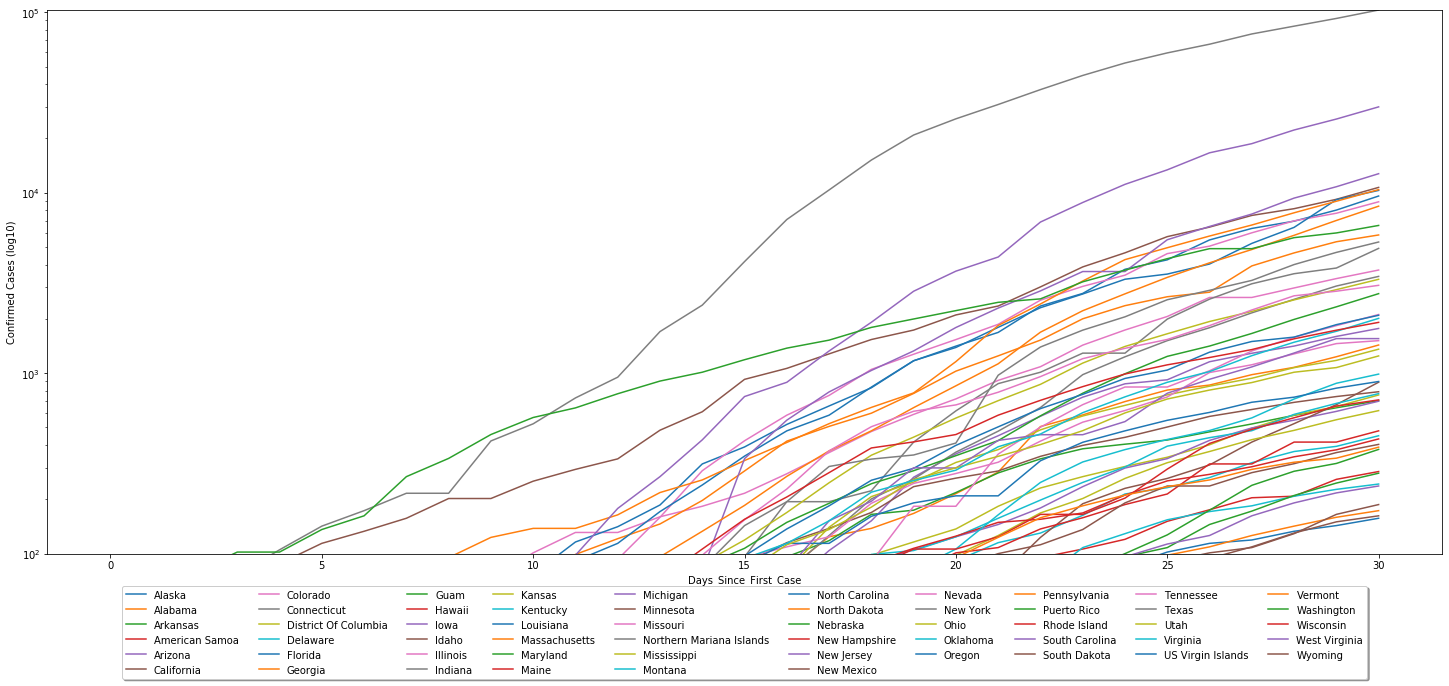

In [20]:
plt.figure(figsize=(25,10))
for state in Testing_DF['State'].unique() :
    subbed = Testing_DF[Testing_DF['State'] == state]
    #dates_xaxis = subbed['Date'].apply(lambda  x : datetime.datetime.strptime(x,'%m/%d/%y'))
    dates_xaxis = subbed['Days_Since_First_Case']
    plt.plot(dates_xaxis,subbed['Positive'])
plt.yscale('log')
plt.legend(Testing_DF['State'].unique(),loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)
plt.xlabel('Days_Since_First_Case')
plt.ylabel('Confirmed Cases (log10)')
plt.ylim(100,max(Testing_DF['Positive']))
plt.show()

# Work with distance (proximity) logic

In [52]:
# Read in Merged Dataset.

Merged = pd.read_csv('data/MASTER_cases_population_beds.txt',sep='\t')

In [53]:
Merged.shape

(4023, 36)

In [54]:
count = 0
ind_remove = []
diff_rows = set()
for i,v in Merged.iterrows() :
    if v['state_code'] != v['state.code'] :
        count +=1
        ind_remove.append(i)
        diff_rows.add(str(v['state_code'])+'_' + str(v['state.code']))
print(count)
print(*list(diff_rows)[::10],sep=',')

2660
AL_NC,LA_WI,LA_PA,AL_IA,TX_GA,DC_KY,LA_AL,MA_MD,IN_MO,NV_KS,DC_UT,PA_VA,TN_WI,AL_TN,DC_VT,MS_IL,LA_IN,TX_CO,DC_TN,OH_NC


In [55]:
Merged.drop(ind_remove,axis=0,inplace=True)

In [56]:
Merged.shape

(1363, 36)

In [31]:
cols_keep = ['UID','fips','data','cases','deaths','X2019.x','state_code','Total Hospital Beds',
 'Total ICU Beds','Potentially Available Hospital Beds','Potentially Available ICU Beds','Adult']

Index(['UID', 'fips', 'date', 'cases', 'deaths', 'Census.x', 'Estimates.Base',
       'X2010', 'X2011', 'X2012', 'X2013', 'X2014', 'X2015', 'X2016', 'X2017',
       'X2018', 'X2019.x', 'state_code', 'Total Hospital Beds',
       'Total ICU Beds', 'Available Hospital Beds',
       'Potentially Available Hospital Beds', 'Available ICU Beds',
       'Potentially Available ICU Beds', 'Adult Population',
       'Population 65 over', 'abrev', 'state.code', 'Lat', 'Long_', 'X',
       'Census.y', 'X2019.y', 'County', 'State', 'county'],
      dtype='object')

In [329]:
# Attempt merge

DF1 = pd.read_csv('data/US_County_Level.csv')
DF2 = pd.read_csv('data/HealthCare_Capacity.txt',sep='\t')
DF3 = pd.read_csv('data/County_Areas.csv')
DF4 = pd.read_csv('data/FIPS_map.csv')
DF5 = pd.read_csv('data/US_County_Population.txt',sep='\t')
state_mapping = pd.read_csv('data/new_state_mapping.txt',sep='\t')

DF2.drop(['Unnamed: 9', 'Unnamed: 10','Unnamed: 11'],axis=1,inplace=True)

DF5 = DF5[['Geographic Area','2019']]

In [330]:
state_map_use = dict(zip(state_mapping.State2,state_mapping.State1))

DF1.state = DF1.state.map(state_map_use)

In [331]:
DF1_4 = pd.merge(DF1,DF4,'left',left_on='fips',right_on='FIPS')
DF1_4 = DF1_4.drop(['FIPS'],axis=1)
DF1_4['Unique_ID'] = ['_'.join([v['county'],v['state']]) for i,v in DF1_4.iterrows()]
DF1_4 = DF1_4[['Unique_ID','date', 'county', 'state', 'fips', 'cases', 'deaths', 'Lat', 'Long_']]

In [332]:
DF1_4.head()

,Unique_ID,date,county,state,fips,cases,deaths,Lat,Long_
0,Snohomish_Washington,2020-01-21,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070
1,Snohomish_Washington,2020-01-22,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070
2,Snohomish_Washington,2020-01-23,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070
3,Cook_Illinois,2020-01-24,Cook,Illinois,17031.0,1,0,41.841448,-87.816588
4,Snohomish_Washington,2020-01-24,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070


In [333]:
DF2['State'] = [v['HRR'].split(', ')[1].strip() for i,v in DF2.iterrows()]

state_map_use = dict(zip(state_mapping.state_code,state_mapping.State1))

DF2.State = DF2.State.map(state_map_use)

In [334]:
DF2['Unique_ID'] = ['_'.join([v['HRR'].split(',')[0],v['State']]) for i,v in DF2.iterrows()]

DF2.drop(['HRR','State'],axis=1,inplace=True)

In [335]:
DF1_4_2 = pd.merge(DF1_4,DF2,'left',on='Unique_ID')

In [336]:
DF1_4_2.head()

,Unique_ID,date,county,state,fips,cases,deaths,Lat,Long_,Total Hospital Beds,Total ICU Beds,Available Hospital Beds,Potentially Available Hospital Beds*,Available ICU Beds,Potentially Available ICU Beds*,Adult Population,Population 65+
0,Snohomish_Washington,2020-01-21,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Snohomish_Washington,2020-01-22,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Snohomish_Washington,2020-01-23,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cook_Illinois,2020-01-24,Cook,Illinois,17031.0,1,0,41.841448,-87.816588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Snohomish_Washington,2020-01-24,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [337]:
state_map_use = dict(zip(state_mapping.State3,state_mapping.State1))
state_map_use = {k:v for k,v in state_map_use.items() if k == k}

DF3.State = DF3.State.map(state_map_use)

DF3['Unique_ID'] = ['_'.join([v['County'],v['State']]) for i,v in DF3.iterrows()]

DF3.drop(['State','County'],axis=1,inplace=True)

In [338]:
DF3.head()

,Area (sqmi),Unique_ID
0,594.44,Autauga County_Alabama
1,1589.78,Baldwin County_Alabama
2,884.88,Barbour County_Alabama
3,622.58,Bibb County_Alabama
4,644.78,Blount County_Alabama


In [339]:
DF1_4_2_3 = pd.merge(DF1_4_2,DF3,'left',on='Unique_ID')

In [340]:
DF1_4_2_3.head()

,Unique_ID,date,county,state,fips,cases,deaths,Lat,Long_,Total Hospital Beds,Total ICU Beds,Available Hospital Beds,Potentially Available Hospital Beds*,Available ICU Beds,Potentially Available ICU Beds*,Adult Population,Population 65+,Area (sqmi)
0,Snohomish_Washington,2020-01-21,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Snohomish_Washington,2020-01-22,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Snohomish_Washington,2020-01-23,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cook_Illinois,2020-01-24,Cook,Illinois,17031.0,1,0,41.841448,-87.816588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Snohomish_Washington,2020-01-24,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [341]:
county_area = [v['Geographic Area'].split(',') for i,v in DF5.iterrows()]
DF5['County'] = [v[0].replace('.','') for v in county_area]
DF5['State'] = [v[1].strip() for v in county_area]

DF5['Unique_ID'] = ['_'.join([v['County'],v['State']]) for i,v in DF5.iterrows()]

In [342]:
DF5.drop(['Geographic Area','County','State'],axis=1,inplace=True)

In [343]:
DFAll = pd.merge(DF1_4_2_3,DF5,'left',on='Unique_ID')

In [344]:
DFAll.head()

,Unique_ID,date,county,state,fips,cases,deaths,Lat,Long_,Total Hospital Beds,Total ICU Beds,Available Hospital Beds,Potentially Available Hospital Beds*,Available ICU Beds,Potentially Available ICU Beds*,Adult Population,Population 65+,Area (sqmi),2019
0,Snohomish_Washington,2020-01-21,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Snohomish_Washington,2020-01-22,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Snohomish_Washington,2020-01-23,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cook_Illinois,2020-01-24,Cook,Illinois,17031.0,1,0,41.841448,-87.816588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Snohomish_Washington,2020-01-24,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [345]:
DFAll.columns = ['Unique_ID','date','county','state','fips','cases','deaths','Latitude','Longitude',
                'Total Hospital Beds', 'Total ICU Beds','Available Hospital Beds',
                 'Potentially Available Hospital Beds','Available ICU Beds',
                 'Potentially Available ICU Beds','Adult Population', 'Population 65+','Area (sqmi)','Population']

In [346]:
for i,col in enumerate(DFAll.columns) :
    new_col = col.replace(' ','_')
    DFAll.rename(columns={col:new_col},inplace=True)

In [347]:
DFAll.head()

,Unique_ID,date,county,state,fips,cases,deaths,Latitude,Longitude,Total_Hospital_Beds,Total_ICU_Beds,Available_Hospital_Beds,Potentially_Available_Hospital_Beds,Available_ICU_Beds,Potentially_Available_ICU_Beds,Adult_Population,Population_65+,Area_(sqmi),Population
0,Snohomish_Washington,2020-01-21,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Snohomish_Washington,2020-01-22,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Snohomish_Washington,2020-01-23,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cook_Illinois,2020-01-24,Cook,Illinois,17031.0,1,0,41.841448,-87.816588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Snohomish_Washington,2020-01-24,Snohomish,Washington,53061.0,1,0,48.046160,-121.717070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
DFAll.shape

(28909, 19)

In [349]:
DFAll.to_csv('data_cleaned/MERGED_PETER.csv',index=False)